# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

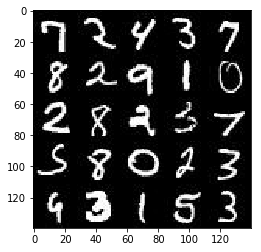

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

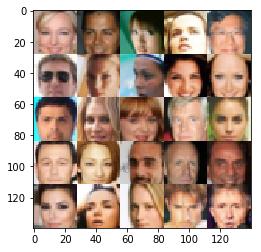

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    image = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), 'image')
    noise = tf.placeholder(tf.float32, (None, z_dim), 'noise')
    lr = tf.placeholder(tf.float32, name='learning_rate')

    return (image, noise, lr)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [7]:
def discriminator(images, reuse=False, alpha=0.2, is_train=True):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :param alpha: Float for leaky relu activation function
    :param is_train: Boolean if the model is training
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer 28x28x3
        # No batch normalization on first layer as per dcgan lesson
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha*x1, x1)
        
        # Input layer 2 14x14x64
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha*bn2, bn2)
        
        # Input layer 3 7x7x128
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha*bn3, bn3)
        
        # Input layer 4 4x4x256
        flattened = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flattened, 1)
        out = tf.sigmoid(logits)
        
    return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :param alpha: Float for leaky relu activation function 
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        # Layer 1 fully connected
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(alpha*bn1, bn1)
        
        # Input layer 2 7x7x256
        x2 = tf.layers.conv2d_transpose(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha*bn2, bn2)
        
        # Input layer 3 14x14x128
        x3 = tf.layers.conv2d_transpose(relu2, 64, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha*bn3, bn3)
        
        # Input layer 4 28x28x64
        # Output layer
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=1, padding='same')
        
        out = tf.tanh(logits) * 0.5
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_out = generator(input_z, out_channel_dim, is_train=True)
    d_out_real, d_logits_real = discriminator(input_real, reuse=False)
    d_out_fake, d_logits_fake = discriminator(g_out, reuse=True)
    
    # Discriminator loss
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                         labels=tf.ones_like(d_logits_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                         labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                    labels=tf.ones_like(d_logits_fake)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train, g_train


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Build the model
    out_dim = len(data_image_mode)
    real_inp, z_inp, lr = model_inputs(28, 28, out_dim, z_dim)
    d_loss, g_loss = model_loss(real_inp, z_inp, out_dim)
    d_train, g_train = model_opt(d_loss, g_loss, lr, beta1)
    
    # Run the model
    steps = 0
    show_every = 20
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # Generate noise
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                sess.run(d_train, feed_dict={real_inp: batch_images, z_inp: batch_z, lr: learning_rate})
                sess.run(g_train, feed_dict={real_inp: batch_images, z_inp: batch_z, lr: learning_rate})
                
                # Calculate, print and store losses. Show generated images
                if steps % show_every == 0:
                    loss_d = d_loss.eval({real_inp: batch_images, z_inp: batch_z})
                    loss_g = g_loss.eval({real_inp: batch_images, z_inp: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(loss_d),
                          "Generator Loss: {:.4f}".format(loss_g))
                if steps % (show_every * 5) == 0:
                    show_generator_output(sess, 1, z_inp, out_dim, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.6376... Generator Loss: 0.1244
Epoch 1/2... Discriminator Loss: 1.0960... Generator Loss: 1.2247
Epoch 1/2... Discriminator Loss: 0.8456... Generator Loss: 1.2387
Epoch 1/2... Discriminator Loss: 1.5125... Generator Loss: 0.3951
Epoch 1/2... Discriminator Loss: 1.3456... Generator Loss: 0.6167


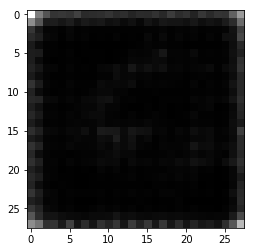

Epoch 1/2... Discriminator Loss: 1.2345... Generator Loss: 0.9217
Epoch 1/2... Discriminator Loss: 1.1977... Generator Loss: 1.1737
Epoch 1/2... Discriminator Loss: 1.4137... Generator Loss: 0.4461
Epoch 1/2... Discriminator Loss: 1.0438... Generator Loss: 0.7778
Epoch 1/2... Discriminator Loss: 0.8894... Generator Loss: 0.9877


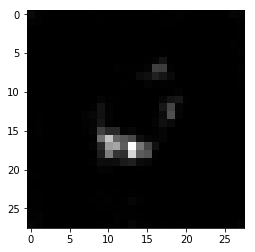

Epoch 1/2... Discriminator Loss: 1.2240... Generator Loss: 0.4463
Epoch 1/2... Discriminator Loss: 0.9635... Generator Loss: 0.6907
Epoch 1/2... Discriminator Loss: 0.8132... Generator Loss: 1.0995
Epoch 1/2... Discriminator Loss: 1.2233... Generator Loss: 0.4561
Epoch 1/2... Discriminator Loss: 0.6319... Generator Loss: 1.5359


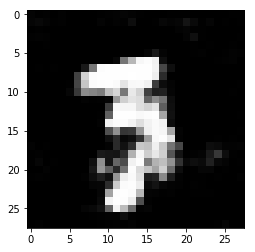

Epoch 1/2... Discriminator Loss: 0.7211... Generator Loss: 1.1948
Epoch 1/2... Discriminator Loss: 0.6934... Generator Loss: 1.3249
Epoch 1/2... Discriminator Loss: 0.7805... Generator Loss: 1.6281
Epoch 1/2... Discriminator Loss: 0.8633... Generator Loss: 0.9719
Epoch 1/2... Discriminator Loss: 0.9646... Generator Loss: 0.8902


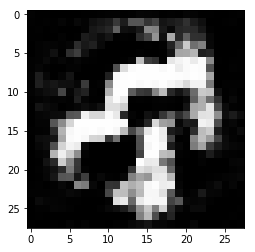

Epoch 1/2... Discriminator Loss: 0.8039... Generator Loss: 0.8670
Epoch 1/2... Discriminator Loss: 0.7703... Generator Loss: 1.1309
Epoch 1/2... Discriminator Loss: 0.9351... Generator Loss: 0.8207
Epoch 1/2... Discriminator Loss: 0.8720... Generator Loss: 0.7587
Epoch 1/2... Discriminator Loss: 0.8402... Generator Loss: 0.8864


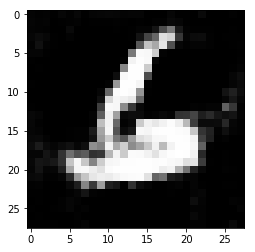

Epoch 1/2... Discriminator Loss: 1.3696... Generator Loss: 0.3384
Epoch 1/2... Discriminator Loss: 0.9212... Generator Loss: 0.9507
Epoch 1/2... Discriminator Loss: 1.2113... Generator Loss: 0.5518
Epoch 1/2... Discriminator Loss: 0.9159... Generator Loss: 0.8775
Epoch 1/2... Discriminator Loss: 0.9755... Generator Loss: 2.1379


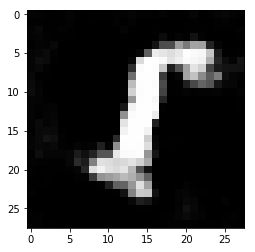

Epoch 1/2... Discriminator Loss: 0.7571... Generator Loss: 1.2563
Epoch 1/2... Discriminator Loss: 0.9531... Generator Loss: 0.7195
Epoch 1/2... Discriminator Loss: 1.1950... Generator Loss: 0.5261
Epoch 1/2... Discriminator Loss: 0.9461... Generator Loss: 0.6241
Epoch 1/2... Discriminator Loss: 0.9884... Generator Loss: 0.6369


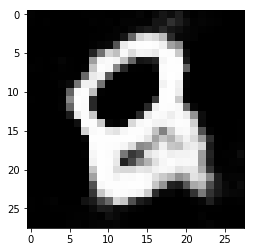

Epoch 1/2... Discriminator Loss: 0.9165... Generator Loss: 0.8933
Epoch 1/2... Discriminator Loss: 0.9280... Generator Loss: 0.7971
Epoch 1/2... Discriminator Loss: 0.9538... Generator Loss: 0.7332
Epoch 1/2... Discriminator Loss: 1.0343... Generator Loss: 0.6855
Epoch 1/2... Discriminator Loss: 0.8509... Generator Loss: 1.1794


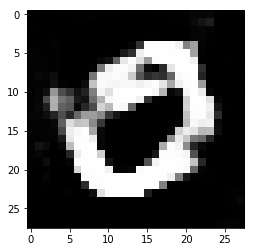

Epoch 1/2... Discriminator Loss: 0.8965... Generator Loss: 0.7486
Epoch 1/2... Discriminator Loss: 0.9241... Generator Loss: 0.7072
Epoch 1/2... Discriminator Loss: 0.9822... Generator Loss: 0.9604
Epoch 1/2... Discriminator Loss: 0.6802... Generator Loss: 1.0809
Epoch 1/2... Discriminator Loss: 0.7642... Generator Loss: 1.3462


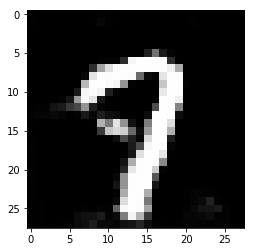

Epoch 1/2... Discriminator Loss: 0.9152... Generator Loss: 0.8359
Epoch 1/2... Discriminator Loss: 1.0433... Generator Loss: 0.5787
Epoch 1/2... Discriminator Loss: 1.2182... Generator Loss: 0.5114
Epoch 1/2... Discriminator Loss: 0.9568... Generator Loss: 0.6411
Epoch 1/2... Discriminator Loss: 0.7756... Generator Loss: 1.1894


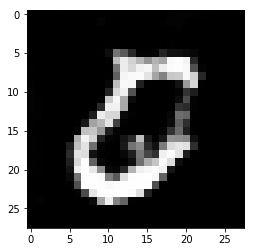

Epoch 1/2... Discriminator Loss: 0.7416... Generator Loss: 0.9226
Epoch 1/2... Discriminator Loss: 0.6057... Generator Loss: 1.3546
Epoch 1/2... Discriminator Loss: 0.6266... Generator Loss: 1.3117
Epoch 1/2... Discriminator Loss: 1.0527... Generator Loss: 0.5773
Epoch 1/2... Discriminator Loss: 0.5594... Generator Loss: 1.5483


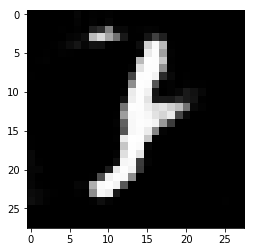

Epoch 1/2... Discriminator Loss: 0.6047... Generator Loss: 1.6479
Epoch 1/2... Discriminator Loss: 0.8731... Generator Loss: 0.7344
Epoch 1/2... Discriminator Loss: 0.7017... Generator Loss: 1.2722
Epoch 1/2... Discriminator Loss: 0.8006... Generator Loss: 0.8860
Epoch 1/2... Discriminator Loss: 0.9913... Generator Loss: 0.5746


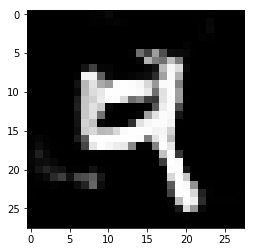

Epoch 1/2... Discriminator Loss: 1.1957... Generator Loss: 2.9564
Epoch 1/2... Discriminator Loss: 0.9573... Generator Loss: 0.7243
Epoch 1/2... Discriminator Loss: 0.7732... Generator Loss: 0.9536
Epoch 1/2... Discriminator Loss: 1.2180... Generator Loss: 0.4743
Epoch 1/2... Discriminator Loss: 0.6708... Generator Loss: 1.4243


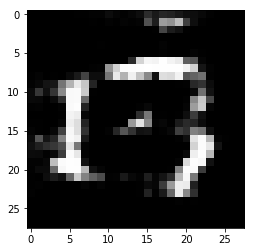

Epoch 1/2... Discriminator Loss: 0.7831... Generator Loss: 1.3640
Epoch 1/2... Discriminator Loss: 0.9498... Generator Loss: 0.6537
Epoch 1/2... Discriminator Loss: 0.8974... Generator Loss: 0.7142
Epoch 1/2... Discriminator Loss: 0.8912... Generator Loss: 0.6762
Epoch 1/2... Discriminator Loss: 0.8595... Generator Loss: 1.1466


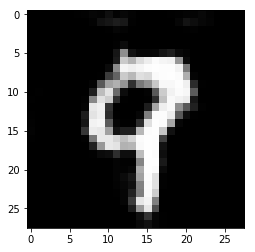

Epoch 1/2... Discriminator Loss: 0.5906... Generator Loss: 1.1996
Epoch 1/2... Discriminator Loss: 0.8003... Generator Loss: 0.8368
Epoch 1/2... Discriminator Loss: 0.9185... Generator Loss: 0.7812
Epoch 1/2... Discriminator Loss: 0.9668... Generator Loss: 0.6491
Epoch 1/2... Discriminator Loss: 0.8043... Generator Loss: 0.9994


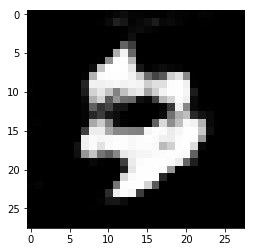

Epoch 1/2... Discriminator Loss: 3.9948... Generator Loss: 0.0327
Epoch 1/2... Discriminator Loss: 0.7835... Generator Loss: 0.9997
Epoch 1/2... Discriminator Loss: 0.7692... Generator Loss: 0.9510
Epoch 1/2... Discriminator Loss: 0.9515... Generator Loss: 0.7261
Epoch 1/2... Discriminator Loss: 1.6920... Generator Loss: 0.3321


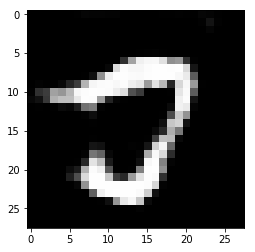

Epoch 1/2... Discriminator Loss: 0.6443... Generator Loss: 1.3250
Epoch 1/2... Discriminator Loss: 1.0071... Generator Loss: 0.7064
Epoch 1/2... Discriminator Loss: 1.3514... Generator Loss: 0.4956
Epoch 1/2... Discriminator Loss: 0.7942... Generator Loss: 0.8973
Epoch 1/2... Discriminator Loss: 1.4037... Generator Loss: 0.4213


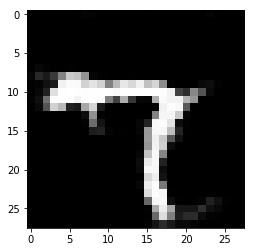

Epoch 1/2... Discriminator Loss: 1.4860... Generator Loss: 1.8343
Epoch 1/2... Discriminator Loss: 1.0800... Generator Loss: 0.6573
Epoch 1/2... Discriminator Loss: 0.6367... Generator Loss: 1.1550
Epoch 1/2... Discriminator Loss: 0.5750... Generator Loss: 1.1282
Epoch 1/2... Discriminator Loss: 0.5323... Generator Loss: 1.4576


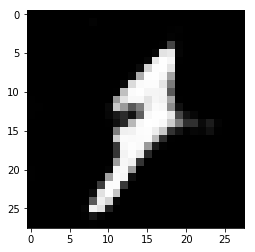

Epoch 1/2... Discriminator Loss: 0.8282... Generator Loss: 2.6985
Epoch 1/2... Discriminator Loss: 0.6159... Generator Loss: 1.4272
Epoch 1/2... Discriminator Loss: 0.7610... Generator Loss: 0.9236
Epoch 2/2... Discriminator Loss: 0.9179... Generator Loss: 0.7016
Epoch 2/2... Discriminator Loss: 0.5286... Generator Loss: 1.4056


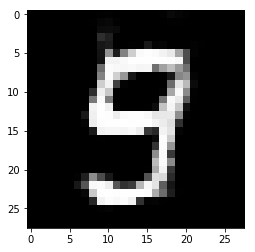

Epoch 2/2... Discriminator Loss: 0.3789... Generator Loss: 1.8566
Epoch 2/2... Discriminator Loss: 0.8749... Generator Loss: 0.8357
Epoch 2/2... Discriminator Loss: 0.5705... Generator Loss: 1.3162
Epoch 2/2... Discriminator Loss: 0.7161... Generator Loss: 1.5312
Epoch 2/2... Discriminator Loss: 0.9624... Generator Loss: 0.5974


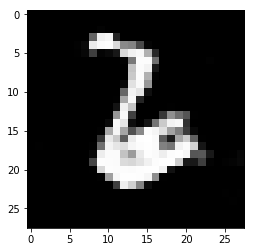

Epoch 2/2... Discriminator Loss: 0.8513... Generator Loss: 0.8231
Epoch 2/2... Discriminator Loss: 0.8328... Generator Loss: 0.7726
Epoch 2/2... Discriminator Loss: 0.8038... Generator Loss: 0.8312
Epoch 2/2... Discriminator Loss: 0.7567... Generator Loss: 1.0728
Epoch 2/2... Discriminator Loss: 0.7154... Generator Loss: 1.0463


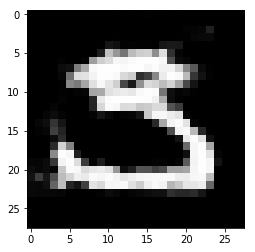

Epoch 2/2... Discriminator Loss: 0.8926... Generator Loss: 0.8793
Epoch 2/2... Discriminator Loss: 0.5582... Generator Loss: 1.3369
Epoch 2/2... Discriminator Loss: 0.6207... Generator Loss: 1.0346
Epoch 2/2... Discriminator Loss: 0.5249... Generator Loss: 1.5321
Epoch 2/2... Discriminator Loss: 0.4164... Generator Loss: 1.4700


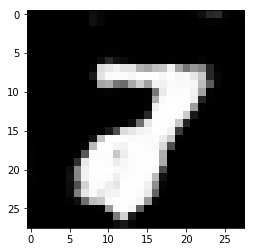

Epoch 2/2... Discriminator Loss: 0.5221... Generator Loss: 1.3772
Epoch 2/2... Discriminator Loss: 0.5120... Generator Loss: 1.3150
Epoch 2/2... Discriminator Loss: 0.4702... Generator Loss: 1.3409
Epoch 2/2... Discriminator Loss: 0.6869... Generator Loss: 1.0605
Epoch 2/2... Discriminator Loss: 0.6805... Generator Loss: 0.9858


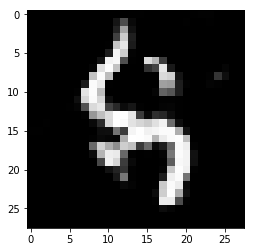

Epoch 2/2... Discriminator Loss: 0.5089... Generator Loss: 1.9697
Epoch 2/2... Discriminator Loss: 1.9345... Generator Loss: 0.2003
Epoch 2/2... Discriminator Loss: 1.0343... Generator Loss: 0.7297
Epoch 2/2... Discriminator Loss: 0.9233... Generator Loss: 0.7422
Epoch 2/2... Discriminator Loss: 0.5906... Generator Loss: 1.4466


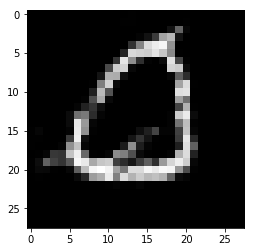

Epoch 2/2... Discriminator Loss: 1.3083... Generator Loss: 0.4334
Epoch 2/2... Discriminator Loss: 0.9921... Generator Loss: 0.7775
Epoch 2/2... Discriminator Loss: 0.6085... Generator Loss: 1.1797
Epoch 2/2... Discriminator Loss: 0.6595... Generator Loss: 0.9511
Epoch 2/2... Discriminator Loss: 0.7264... Generator Loss: 1.0677


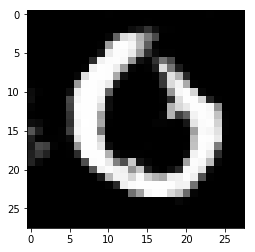

Epoch 2/2... Discriminator Loss: 0.4909... Generator Loss: 1.5015
Epoch 2/2... Discriminator Loss: 1.3041... Generator Loss: 0.5046
Epoch 2/2... Discriminator Loss: 0.3788... Generator Loss: 1.7544
Epoch 2/2... Discriminator Loss: 0.3244... Generator Loss: 1.9122
Epoch 2/2... Discriminator Loss: 0.9460... Generator Loss: 0.7188


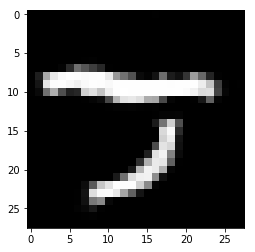

Epoch 2/2... Discriminator Loss: 1.2794... Generator Loss: 0.5344
Epoch 2/2... Discriminator Loss: 0.6473... Generator Loss: 1.0053
Epoch 2/2... Discriminator Loss: 0.7359... Generator Loss: 0.9949
Epoch 2/2... Discriminator Loss: 0.6321... Generator Loss: 1.2302
Epoch 2/2... Discriminator Loss: 0.5400... Generator Loss: 2.4245


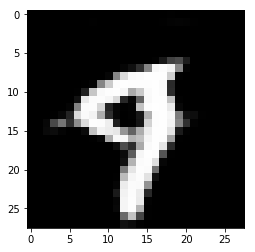

Epoch 2/2... Discriminator Loss: 0.6799... Generator Loss: 1.0124
Epoch 2/2... Discriminator Loss: 0.4646... Generator Loss: 1.3240
Epoch 2/2... Discriminator Loss: 0.7365... Generator Loss: 0.8886
Epoch 2/2... Discriminator Loss: 0.5858... Generator Loss: 0.9994
Epoch 2/2... Discriminator Loss: 1.2212... Generator Loss: 4.3958


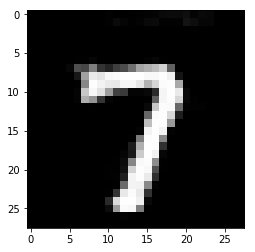

Epoch 2/2... Discriminator Loss: 0.5055... Generator Loss: 1.4342
Epoch 2/2... Discriminator Loss: 0.6270... Generator Loss: 1.1023
Epoch 2/2... Discriminator Loss: 0.9001... Generator Loss: 0.6573
Epoch 2/2... Discriminator Loss: 0.4348... Generator Loss: 1.6235
Epoch 2/2... Discriminator Loss: 0.3380... Generator Loss: 1.9939


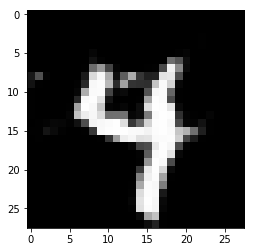

Epoch 2/2... Discriminator Loss: 0.5145... Generator Loss: 1.1974
Epoch 2/2... Discriminator Loss: 0.9707... Generator Loss: 2.5209
Epoch 2/2... Discriminator Loss: 0.7776... Generator Loss: 0.8957
Epoch 2/2... Discriminator Loss: 0.4714... Generator Loss: 1.4997
Epoch 2/2... Discriminator Loss: 0.4818... Generator Loss: 1.4672


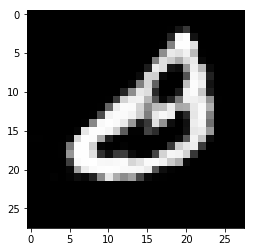

Epoch 2/2... Discriminator Loss: 0.5886... Generator Loss: 1.2960
Epoch 2/2... Discriminator Loss: 0.5343... Generator Loss: 1.3911
Epoch 2/2... Discriminator Loss: 0.2867... Generator Loss: 2.4604
Epoch 2/2... Discriminator Loss: 0.2802... Generator Loss: 2.3669
Epoch 2/2... Discriminator Loss: 0.3378... Generator Loss: 1.7578


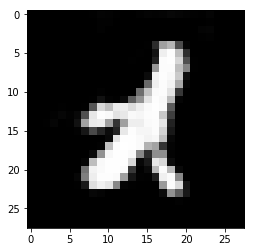

Epoch 2/2... Discriminator Loss: 0.5125... Generator Loss: 1.6688
Epoch 2/2... Discriminator Loss: 0.7650... Generator Loss: 0.8469
Epoch 2/2... Discriminator Loss: 0.7829... Generator Loss: 0.8470
Epoch 2/2... Discriminator Loss: 0.5323... Generator Loss: 1.2370
Epoch 2/2... Discriminator Loss: 0.4987... Generator Loss: 1.2779


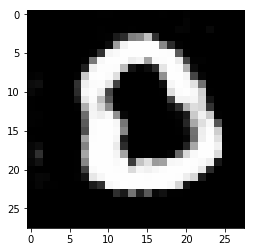

Epoch 2/2... Discriminator Loss: 0.4294... Generator Loss: 1.5503
Epoch 2/2... Discriminator Loss: 0.6245... Generator Loss: 1.1128
Epoch 2/2... Discriminator Loss: 1.5122... Generator Loss: 2.7662
Epoch 2/2... Discriminator Loss: 0.3752... Generator Loss: 1.6636
Epoch 2/2... Discriminator Loss: 0.6183... Generator Loss: 1.0877


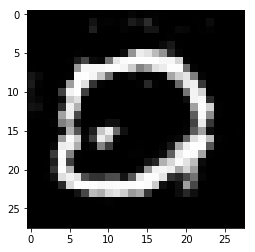

Epoch 2/2... Discriminator Loss: 0.7652... Generator Loss: 0.8798
Epoch 2/2... Discriminator Loss: 0.5783... Generator Loss: 1.6536
Epoch 2/2... Discriminator Loss: 1.1238... Generator Loss: 0.6581
Epoch 2/2... Discriminator Loss: 0.3324... Generator Loss: 1.7495
Epoch 2/2... Discriminator Loss: 0.6255... Generator Loss: 1.0889


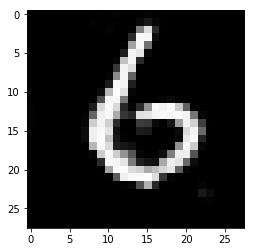

Epoch 2/2... Discriminator Loss: 0.9882... Generator Loss: 0.7890
Epoch 2/2... Discriminator Loss: 0.5253... Generator Loss: 1.2286
Epoch 2/2... Discriminator Loss: 0.7400... Generator Loss: 1.0824
Epoch 2/2... Discriminator Loss: 0.6201... Generator Loss: 1.0642
Epoch 2/2... Discriminator Loss: 0.9411... Generator Loss: 0.8890


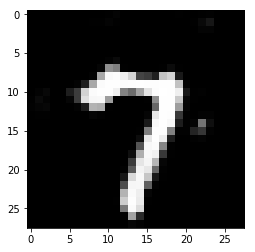

Epoch 2/2... Discriminator Loss: 0.4884... Generator Loss: 1.3411
Epoch 2/2... Discriminator Loss: 0.5641... Generator Loss: 1.0838
Epoch 2/2... Discriminator Loss: 0.5973... Generator Loss: 1.2255
Epoch 2/2... Discriminator Loss: 0.4364... Generator Loss: 1.5490
Epoch 2/2... Discriminator Loss: 0.4172... Generator Loss: 1.4661


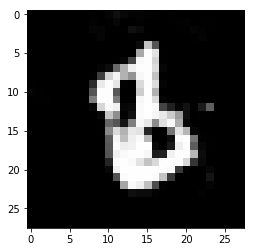

Epoch 2/2... Discriminator Loss: 1.3685... Generator Loss: 0.4727
Epoch 2/2... Discriminator Loss: 0.9208... Generator Loss: 0.7887
Epoch 2/2... Discriminator Loss: 0.4309... Generator Loss: 1.4002
Epoch 2/2... Discriminator Loss: 0.5212... Generator Loss: 2.6648
Epoch 2/2... Discriminator Loss: 0.4579... Generator Loss: 1.3896


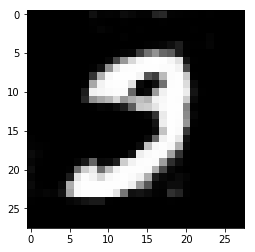

Epoch 2/2... Discriminator Loss: 0.4875... Generator Loss: 1.1624
Epoch 2/2... Discriminator Loss: 0.4488... Generator Loss: 1.4598


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.7945... Generator Loss: 0.9461
Epoch 1/1... Discriminator Loss: 0.9177... Generator Loss: 0.7697
Epoch 1/1... Discriminator Loss: 0.5271... Generator Loss: 1.7135
Epoch 1/1... Discriminator Loss: 0.4282... Generator Loss: 3.5606
Epoch 1/1... Discriminator Loss: 1.1861... Generator Loss: 0.5521


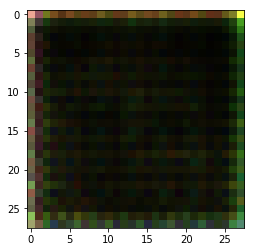

Epoch 1/1... Discriminator Loss: 3.7194... Generator Loss: 0.0368
Epoch 1/1... Discriminator Loss: 0.4951... Generator Loss: 1.2680
Epoch 1/1... Discriminator Loss: 0.2975... Generator Loss: 2.0865
Epoch 1/1... Discriminator Loss: 0.4628... Generator Loss: 5.9788
Epoch 1/1... Discriminator Loss: 1.5753... Generator Loss: 0.4734


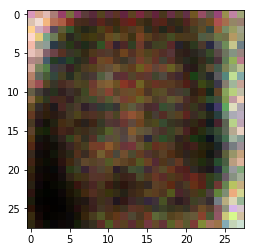

Epoch 1/1... Discriminator Loss: 0.3951... Generator Loss: 2.0392
Epoch 1/1... Discriminator Loss: 0.4384... Generator Loss: 2.3024
Epoch 1/1... Discriminator Loss: 1.1590... Generator Loss: 0.6692
Epoch 1/1... Discriminator Loss: 0.4014... Generator Loss: 1.5781
Epoch 1/1... Discriminator Loss: 0.6631... Generator Loss: 1.6643


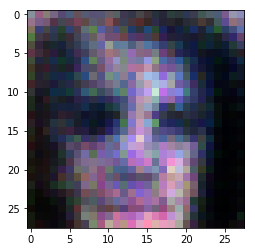

Epoch 1/1... Discriminator Loss: 0.4358... Generator Loss: 2.3762
Epoch 1/1... Discriminator Loss: 0.4448... Generator Loss: 2.9379
Epoch 1/1... Discriminator Loss: 1.1502... Generator Loss: 0.6736
Epoch 1/1... Discriminator Loss: 0.3331... Generator Loss: 3.1769
Epoch 1/1... Discriminator Loss: 0.6098... Generator Loss: 1.4414


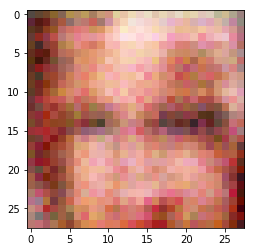

Epoch 1/1... Discriminator Loss: 0.6114... Generator Loss: 1.4175
Epoch 1/1... Discriminator Loss: 1.7045... Generator Loss: 0.3358
Epoch 1/1... Discriminator Loss: 0.2995... Generator Loss: 1.7551
Epoch 1/1... Discriminator Loss: 0.7513... Generator Loss: 1.1421
Epoch 1/1... Discriminator Loss: 0.1202... Generator Loss: 2.7609


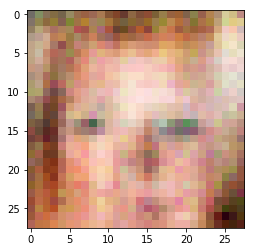

Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.5611
Epoch 1/1... Discriminator Loss: 0.6373... Generator Loss: 1.0448
Epoch 1/1... Discriminator Loss: 0.1722... Generator Loss: 8.8786
Epoch 1/1... Discriminator Loss: 0.6079... Generator Loss: 1.1016
Epoch 1/1... Discriminator Loss: 0.4761... Generator Loss: 3.5975


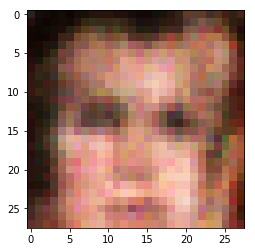

Epoch 1/1... Discriminator Loss: 0.4131... Generator Loss: 5.2222
Epoch 1/1... Discriminator Loss: 0.2359... Generator Loss: 5.2504
Epoch 1/1... Discriminator Loss: 0.1212... Generator Loss: 3.0123
Epoch 1/1... Discriminator Loss: 0.2207... Generator Loss: 2.3285
Epoch 1/1... Discriminator Loss: 1.1794... Generator Loss: 0.5206


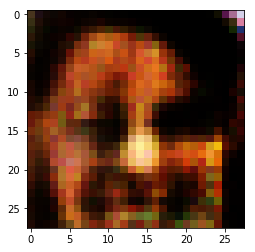

Epoch 1/1... Discriminator Loss: 0.2655... Generator Loss: 2.9094
Epoch 1/1... Discriminator Loss: 0.6309... Generator Loss: 1.0796
Epoch 1/1... Discriminator Loss: 0.4829... Generator Loss: 1.3852
Epoch 1/1... Discriminator Loss: 0.1632... Generator Loss: 2.9099
Epoch 1/1... Discriminator Loss: 0.7098... Generator Loss: 2.9454


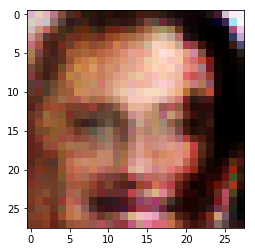

Epoch 1/1... Discriminator Loss: 0.0876... Generator Loss: 3.4595
Epoch 1/1... Discriminator Loss: 0.1785... Generator Loss: 5.8156
Epoch 1/1... Discriminator Loss: 0.1851... Generator Loss: 4.0887
Epoch 1/1... Discriminator Loss: 0.1588... Generator Loss: 5.7768
Epoch 1/1... Discriminator Loss: 0.1205... Generator Loss: 4.9062


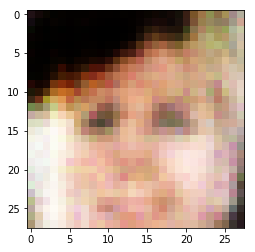

Epoch 1/1... Discriminator Loss: 0.2357... Generator Loss: 3.4086
Epoch 1/1... Discriminator Loss: 0.1142... Generator Loss: 4.8578
Epoch 1/1... Discriminator Loss: 0.5510... Generator Loss: 1.2486
Epoch 1/1... Discriminator Loss: 0.5806... Generator Loss: 1.0768
Epoch 1/1... Discriminator Loss: 0.2425... Generator Loss: 3.0418


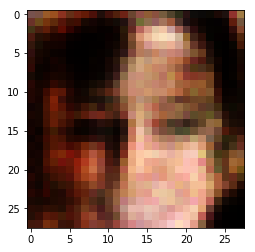

Epoch 1/1... Discriminator Loss: 0.0921... Generator Loss: 3.3851
Epoch 1/1... Discriminator Loss: 0.0784... Generator Loss: 3.7118
Epoch 1/1... Discriminator Loss: 0.0378... Generator Loss: 5.2436
Epoch 1/1... Discriminator Loss: 0.2868... Generator Loss: 2.0511
Epoch 1/1... Discriminator Loss: 0.1696... Generator Loss: 2.3643


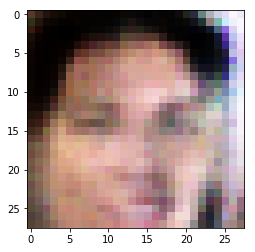

Epoch 1/1... Discriminator Loss: 0.1145... Generator Loss: 4.7620
Epoch 1/1... Discriminator Loss: 1.5972... Generator Loss: 6.7609
Epoch 1/1... Discriminator Loss: 0.1954... Generator Loss: 3.7156
Epoch 1/1... Discriminator Loss: 0.1078... Generator Loss: 3.2864
Epoch 1/1... Discriminator Loss: 0.5757... Generator Loss: 1.0194


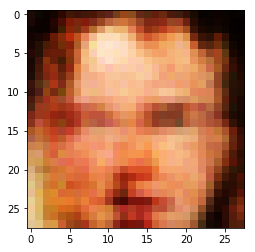

Epoch 1/1... Discriminator Loss: 0.1960... Generator Loss: 5.6695
Epoch 1/1... Discriminator Loss: 0.2672... Generator Loss: 1.8719
Epoch 1/1... Discriminator Loss: 0.1596... Generator Loss: 3.4349
Epoch 1/1... Discriminator Loss: 0.1686... Generator Loss: 3.2518
Epoch 1/1... Discriminator Loss: 0.0834... Generator Loss: 4.6862


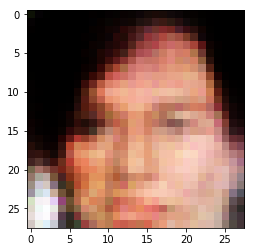

Epoch 1/1... Discriminator Loss: 0.1098... Generator Loss: 4.4847
Epoch 1/1... Discriminator Loss: 0.4269... Generator Loss: 1.4733
Epoch 1/1... Discriminator Loss: 0.1390... Generator Loss: 2.7964
Epoch 1/1... Discriminator Loss: 0.4083... Generator Loss: 2.3386
Epoch 1/1... Discriminator Loss: 0.1174... Generator Loss: 2.7357


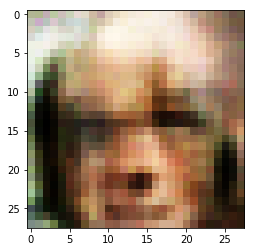

Epoch 1/1... Discriminator Loss: 0.1049... Generator Loss: 3.4825
Epoch 1/1... Discriminator Loss: 0.3094... Generator Loss: 1.9647
Epoch 1/1... Discriminator Loss: 0.2654... Generator Loss: 2.0285
Epoch 1/1... Discriminator Loss: 0.1711... Generator Loss: 2.4152
Epoch 1/1... Discriminator Loss: 0.2090... Generator Loss: 2.4088


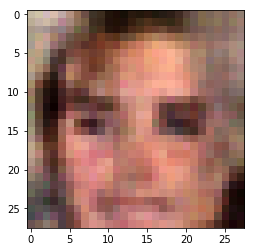

Epoch 1/1... Discriminator Loss: 0.0941... Generator Loss: 4.5602
Epoch 1/1... Discriminator Loss: 1.4856... Generator Loss: 1.4523
Epoch 1/1... Discriminator Loss: 0.4130... Generator Loss: 3.4212
Epoch 1/1... Discriminator Loss: 0.1240... Generator Loss: 2.9906
Epoch 1/1... Discriminator Loss: 0.0930... Generator Loss: 5.0478


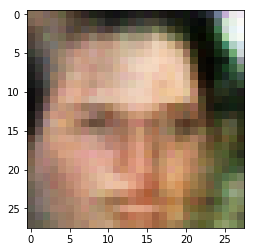

Epoch 1/1... Discriminator Loss: 0.2165... Generator Loss: 2.3412
Epoch 1/1... Discriminator Loss: 0.2916... Generator Loss: 1.7296
Epoch 1/1... Discriminator Loss: 0.0390... Generator Loss: 5.9775
Epoch 1/1... Discriminator Loss: 0.1087... Generator Loss: 4.3045
Epoch 1/1... Discriminator Loss: 0.0763... Generator Loss: 7.6734


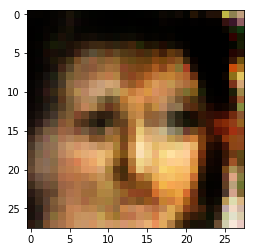

Epoch 1/1... Discriminator Loss: 0.2541... Generator Loss: 2.0472
Epoch 1/1... Discriminator Loss: 0.1720... Generator Loss: 2.7901
Epoch 1/1... Discriminator Loss: 0.6859... Generator Loss: 1.0160
Epoch 1/1... Discriminator Loss: 7.8016... Generator Loss: 11.2236
Epoch 1/1... Discriminator Loss: 0.7068... Generator Loss: 1.3669


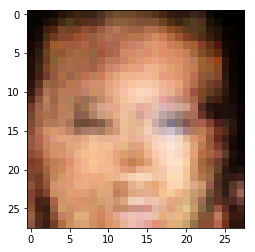

Epoch 1/1... Discriminator Loss: 0.8970... Generator Loss: 0.7366
Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.3965
Epoch 1/1... Discriminator Loss: 0.6086... Generator Loss: 1.0606
Epoch 1/1... Discriminator Loss: 0.6489... Generator Loss: 2.8180
Epoch 1/1... Discriminator Loss: 0.3148... Generator Loss: 1.7961


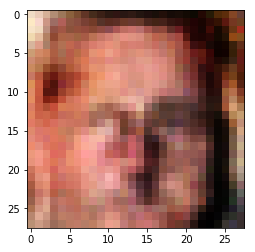

Epoch 1/1... Discriminator Loss: 0.2802... Generator Loss: 1.7850
Epoch 1/1... Discriminator Loss: 0.1004... Generator Loss: 3.0706
Epoch 1/1... Discriminator Loss: 0.3058... Generator Loss: 2.1377
Epoch 1/1... Discriminator Loss: 0.1871... Generator Loss: 2.6425
Epoch 1/1... Discriminator Loss: 0.1321... Generator Loss: 3.5056


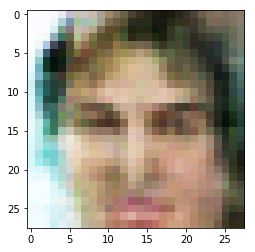

Epoch 1/1... Discriminator Loss: 0.3576... Generator Loss: 1.3950
Epoch 1/1... Discriminator Loss: 1.7503... Generator Loss: 3.2480
Epoch 1/1... Discriminator Loss: 0.8303... Generator Loss: 2.2188
Epoch 1/1... Discriminator Loss: 0.4176... Generator Loss: 1.6580
Epoch 1/1... Discriminator Loss: 2.5132... Generator Loss: 0.1690


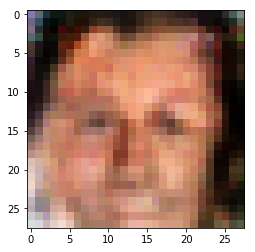

Epoch 1/1... Discriminator Loss: 0.2287... Generator Loss: 2.6193
Epoch 1/1... Discriminator Loss: 0.1546... Generator Loss: 2.9578
Epoch 1/1... Discriminator Loss: 0.3638... Generator Loss: 1.5461
Epoch 1/1... Discriminator Loss: 0.2761... Generator Loss: 1.8810
Epoch 1/1... Discriminator Loss: 0.3668... Generator Loss: 1.7633


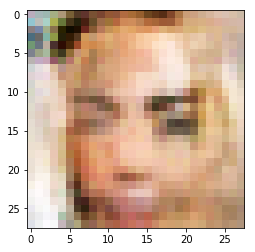

Epoch 1/1... Discriminator Loss: 0.0736... Generator Loss: 3.5836
Epoch 1/1... Discriminator Loss: 0.3231... Generator Loss: 1.8780
Epoch 1/1... Discriminator Loss: 0.2723... Generator Loss: 1.8205
Epoch 1/1... Discriminator Loss: 0.6057... Generator Loss: 3.1461
Epoch 1/1... Discriminator Loss: 0.4126... Generator Loss: 1.5198


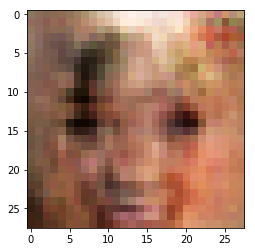

Epoch 1/1... Discriminator Loss: 0.7858... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 0.0835... Generator Loss: 5.0607
Epoch 1/1... Discriminator Loss: 0.1047... Generator Loss: 3.2832
Epoch 1/1... Discriminator Loss: 0.1127... Generator Loss: 2.9641
Epoch 1/1... Discriminator Loss: 1.2368... Generator Loss: 0.5238


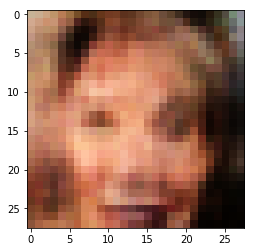

Epoch 1/1... Discriminator Loss: 0.5357... Generator Loss: 1.3095
Epoch 1/1... Discriminator Loss: 0.0918... Generator Loss: 4.3286
Epoch 1/1... Discriminator Loss: 0.0262... Generator Loss: 4.3035
Epoch 1/1... Discriminator Loss: 0.0855... Generator Loss: 3.7895
Epoch 1/1... Discriminator Loss: 0.4051... Generator Loss: 1.6412


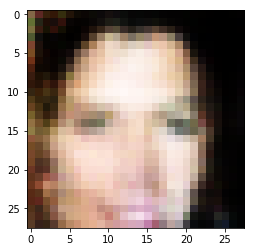

Epoch 1/1... Discriminator Loss: 0.0740... Generator Loss: 3.9755
Epoch 1/1... Discriminator Loss: 0.3048... Generator Loss: 1.7013
Epoch 1/1... Discriminator Loss: 1.5362... Generator Loss: 0.3785
Epoch 1/1... Discriminator Loss: 0.7134... Generator Loss: 4.8921
Epoch 1/1... Discriminator Loss: 0.5959... Generator Loss: 1.3712


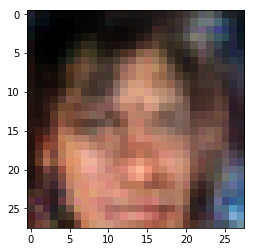

Epoch 1/1... Discriminator Loss: 0.3669... Generator Loss: 1.5768
Epoch 1/1... Discriminator Loss: 0.0992... Generator Loss: 3.6764
Epoch 1/1... Discriminator Loss: 0.1371... Generator Loss: 3.1310
Epoch 1/1... Discriminator Loss: 0.1676... Generator Loss: 2.6767
Epoch 1/1... Discriminator Loss: 0.3525... Generator Loss: 1.5511


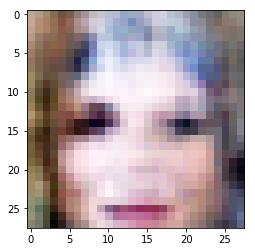

Epoch 1/1... Discriminator Loss: 3.4707... Generator Loss: 4.7088
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.4292
Epoch 1/1... Discriminator Loss: 0.1121... Generator Loss: 3.4920
Epoch 1/1... Discriminator Loss: 0.0804... Generator Loss: 3.9442
Epoch 1/1... Discriminator Loss: 0.5893... Generator Loss: 3.1141


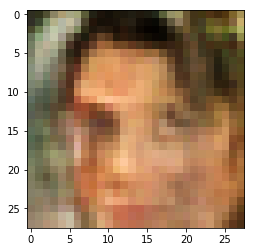

Epoch 1/1... Discriminator Loss: 0.1018... Generator Loss: 3.8127
Epoch 1/1... Discriminator Loss: 0.3980... Generator Loss: 1.5042
Epoch 1/1... Discriminator Loss: 0.7462... Generator Loss: 0.9646
Epoch 1/1... Discriminator Loss: 0.1508... Generator Loss: 5.3237
Epoch 1/1... Discriminator Loss: 0.7609... Generator Loss: 0.9872


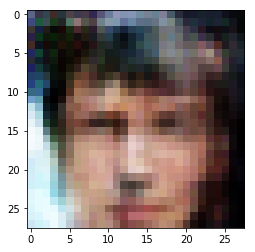

Epoch 1/1... Discriminator Loss: 0.3379... Generator Loss: 1.7237
Epoch 1/1... Discriminator Loss: 0.0159... Generator Loss: 7.5168
Epoch 1/1... Discriminator Loss: 0.1882... Generator Loss: 9.5338
Epoch 1/1... Discriminator Loss: 0.7150... Generator Loss: 0.8640
Epoch 1/1... Discriminator Loss: 0.1406... Generator Loss: 2.9696


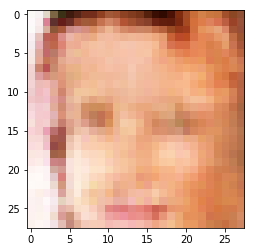

Epoch 1/1... Discriminator Loss: 0.4630... Generator Loss: 1.3194
Epoch 1/1... Discriminator Loss: 0.3639... Generator Loss: 1.5220
Epoch 1/1... Discriminator Loss: 0.5790... Generator Loss: 1.3964
Epoch 1/1... Discriminator Loss: 0.0891... Generator Loss: 3.1284
Epoch 1/1... Discriminator Loss: 0.3670... Generator Loss: 1.6982


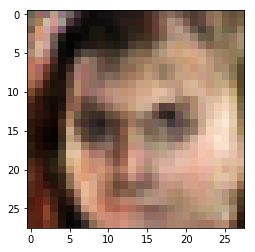

Epoch 1/1... Discriminator Loss: 0.1864... Generator Loss: 2.1345
Epoch 1/1... Discriminator Loss: 0.1667... Generator Loss: 2.2519
Epoch 1/1... Discriminator Loss: 0.3685... Generator Loss: 1.7115
Epoch 1/1... Discriminator Loss: 0.2808... Generator Loss: 1.8049
Epoch 1/1... Discriminator Loss: 0.9524... Generator Loss: 3.7957


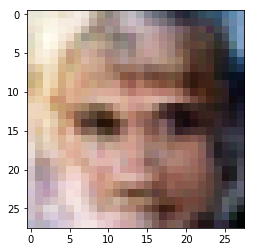

Epoch 1/1... Discriminator Loss: 0.4149... Generator Loss: 2.4908
Epoch 1/1... Discriminator Loss: 0.1726... Generator Loss: 4.2194
Epoch 1/1... Discriminator Loss: 0.1312... Generator Loss: 2.9022
Epoch 1/1... Discriminator Loss: 0.0531... Generator Loss: 3.9848
Epoch 1/1... Discriminator Loss: 0.2188... Generator Loss: 2.3014


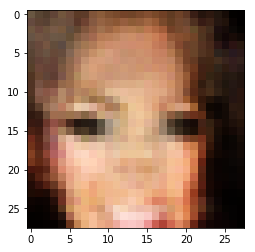

Epoch 1/1... Discriminator Loss: 0.1345... Generator Loss: 2.5351
Epoch 1/1... Discriminator Loss: 1.5458... Generator Loss: 0.4270
Epoch 1/1... Discriminator Loss: 0.7710... Generator Loss: 2.7944
Epoch 1/1... Discriminator Loss: 0.6834... Generator Loss: 1.1412
Epoch 1/1... Discriminator Loss: 0.2976... Generator Loss: 2.1310


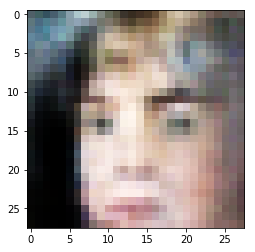

Epoch 1/1... Discriminator Loss: 0.1089... Generator Loss: 3.3697
Epoch 1/1... Discriminator Loss: 0.1412... Generator Loss: 2.8397
Epoch 1/1... Discriminator Loss: 0.2292... Generator Loss: 2.0850
Epoch 1/1... Discriminator Loss: 0.0741... Generator Loss: 3.7159
Epoch 1/1... Discriminator Loss: 0.1382... Generator Loss: 2.7191


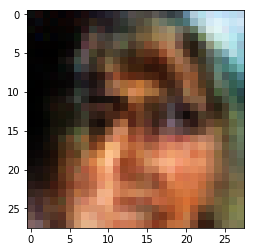

Epoch 1/1... Discriminator Loss: 0.1129... Generator Loss: 3.3443
Epoch 1/1... Discriminator Loss: 2.5142... Generator Loss: 4.9283
Epoch 1/1... Discriminator Loss: 0.8587... Generator Loss: 0.8669
Epoch 1/1... Discriminator Loss: 0.3276... Generator Loss: 2.2543
Epoch 1/1... Discriminator Loss: 0.6078... Generator Loss: 1.1633


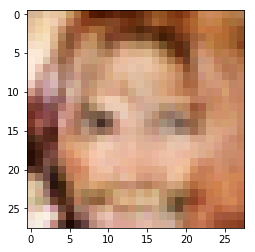

Epoch 1/1... Discriminator Loss: 0.4485... Generator Loss: 1.3731
Epoch 1/1... Discriminator Loss: 0.4086... Generator Loss: 1.3417
Epoch 1/1... Discriminator Loss: 0.2441... Generator Loss: 2.3885
Epoch 1/1... Discriminator Loss: 0.2744... Generator Loss: 1.8065
Epoch 1/1... Discriminator Loss: 0.1428... Generator Loss: 2.6566


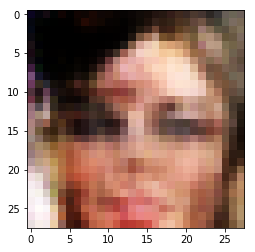

Epoch 1/1... Discriminator Loss: 0.0743... Generator Loss: 4.8697
Epoch 1/1... Discriminator Loss: 0.2612... Generator Loss: 3.2517
Epoch 1/1... Discriminator Loss: 0.4781... Generator Loss: 1.1967
Epoch 1/1... Discriminator Loss: 0.0898... Generator Loss: 2.9095
Epoch 1/1... Discriminator Loss: 0.5722... Generator Loss: 1.0207


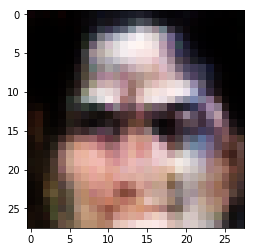

Epoch 1/1... Discriminator Loss: 1.0572... Generator Loss: 3.7497
Epoch 1/1... Discriminator Loss: 0.7326... Generator Loss: 0.9200
Epoch 1/1... Discriminator Loss: 2.0628... Generator Loss: 0.2619
Epoch 1/1... Discriminator Loss: 0.1308... Generator Loss: 2.7477
Epoch 1/1... Discriminator Loss: 0.2782... Generator Loss: 1.7511


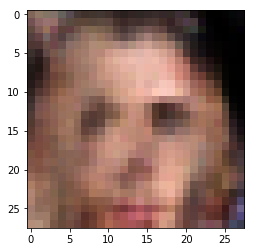

Epoch 1/1... Discriminator Loss: 0.4866... Generator Loss: 1.3140
Epoch 1/1... Discriminator Loss: 0.2075... Generator Loss: 3.5174
Epoch 1/1... Discriminator Loss: 0.2379... Generator Loss: 4.1088
Epoch 1/1... Discriminator Loss: 0.4804... Generator Loss: 1.2505
Epoch 1/1... Discriminator Loss: 0.1992... Generator Loss: 4.7803


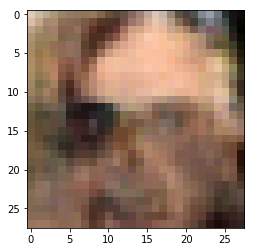

Epoch 1/1... Discriminator Loss: 0.0716... Generator Loss: 5.7752
Epoch 1/1... Discriminator Loss: 0.0971... Generator Loss: 3.9681
Epoch 1/1... Discriminator Loss: 0.1680... Generator Loss: 2.4901
Epoch 1/1... Discriminator Loss: 0.2233... Generator Loss: 2.6959
Epoch 1/1... Discriminator Loss: 0.1888... Generator Loss: 2.3363


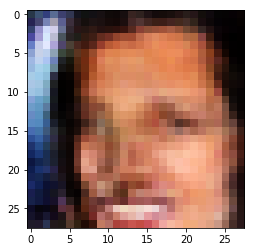

Epoch 1/1... Discriminator Loss: 0.1316... Generator Loss: 3.2383
Epoch 1/1... Discriminator Loss: 0.3766... Generator Loss: 1.4451
Epoch 1/1... Discriminator Loss: 0.3761... Generator Loss: 1.7394
Epoch 1/1... Discriminator Loss: 0.1589... Generator Loss: 2.8151
Epoch 1/1... Discriminator Loss: 0.0802... Generator Loss: 3.7968


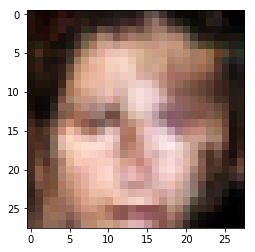

Epoch 1/1... Discriminator Loss: 0.0285... Generator Loss: 5.3757
Epoch 1/1... Discriminator Loss: 0.1732... Generator Loss: 5.8243
Epoch 1/1... Discriminator Loss: 0.5410... Generator Loss: 3.8402
Epoch 1/1... Discriminator Loss: 0.0938... Generator Loss: 4.1057
Epoch 1/1... Discriminator Loss: 0.2319... Generator Loss: 2.5421


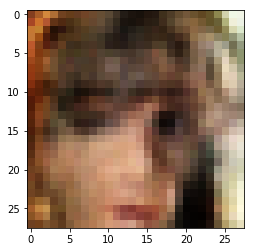

Epoch 1/1... Discriminator Loss: 0.3468... Generator Loss: 1.5739
Epoch 1/1... Discriminator Loss: 0.0586... Generator Loss: 4.1302
Epoch 1/1... Discriminator Loss: 0.6976... Generator Loss: 3.1094
Epoch 1/1... Discriminator Loss: 2.2754... Generator Loss: 0.1672
Epoch 1/1... Discriminator Loss: 1.0654... Generator Loss: 0.6514


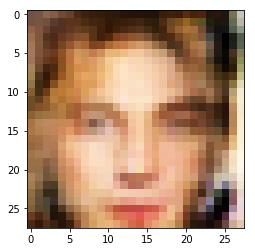

Epoch 1/1... Discriminator Loss: 0.1179... Generator Loss: 3.5053
Epoch 1/1... Discriminator Loss: 0.2302... Generator Loss: 2.1223
Epoch 1/1... Discriminator Loss: 0.4251... Generator Loss: 1.9431
Epoch 1/1... Discriminator Loss: 0.4182... Generator Loss: 4.7452
Epoch 1/1... Discriminator Loss: 0.7008... Generator Loss: 2.4265


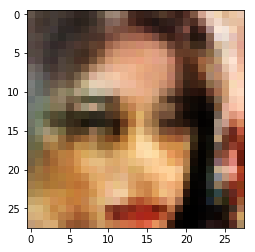

Epoch 1/1... Discriminator Loss: 0.1341... Generator Loss: 3.8800
Epoch 1/1... Discriminator Loss: 0.0503... Generator Loss: 3.8082
Epoch 1/1... Discriminator Loss: 0.0642... Generator Loss: 3.9077
Epoch 1/1... Discriminator Loss: 4.2588... Generator Loss: 6.2897
Epoch 1/1... Discriminator Loss: 0.6574... Generator Loss: 0.9771


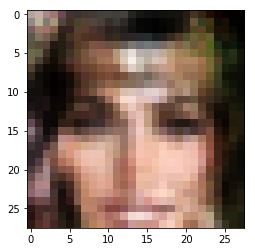

Epoch 1/1... Discriminator Loss: 0.8092... Generator Loss: 0.9397
Epoch 1/1... Discriminator Loss: 0.0701... Generator Loss: 5.3373
Epoch 1/1... Discriminator Loss: 1.1441... Generator Loss: 0.5068
Epoch 1/1... Discriminator Loss: 0.1561... Generator Loss: 2.4587
Epoch 1/1... Discriminator Loss: 0.3637... Generator Loss: 1.5384


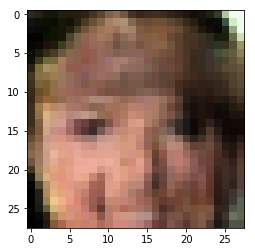

Epoch 1/1... Discriminator Loss: 0.3757... Generator Loss: 2.5812
Epoch 1/1... Discriminator Loss: 0.2387... Generator Loss: 2.4076
Epoch 1/1... Discriminator Loss: 0.7540... Generator Loss: 0.8848
Epoch 1/1... Discriminator Loss: 0.1157... Generator Loss: 3.1819
Epoch 1/1... Discriminator Loss: 0.1611... Generator Loss: 2.6856


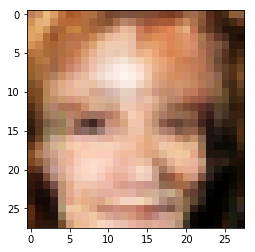

Epoch 1/1... Discriminator Loss: 0.2212... Generator Loss: 2.2036
Epoch 1/1... Discriminator Loss: 0.2066... Generator Loss: 2.2080
Epoch 1/1... Discriminator Loss: 0.2375... Generator Loss: 2.0526
Epoch 1/1... Discriminator Loss: 0.3471... Generator Loss: 1.5705
Epoch 1/1... Discriminator Loss: 1.2213... Generator Loss: 0.4815


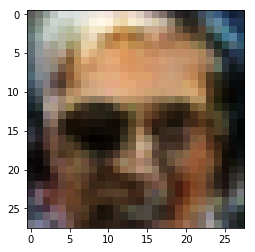

Epoch 1/1... Discriminator Loss: 0.3775... Generator Loss: 1.5581
Epoch 1/1... Discriminator Loss: 0.2227... Generator Loss: 2.1117
Epoch 1/1... Discriminator Loss: 1.3274... Generator Loss: 0.3910
Epoch 1/1... Discriminator Loss: 0.6064... Generator Loss: 1.1714
Epoch 1/1... Discriminator Loss: 0.5208... Generator Loss: 1.7051


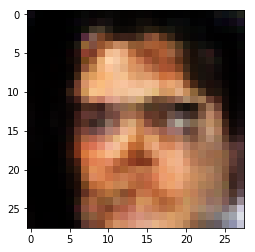

Epoch 1/1... Discriminator Loss: 2.9378... Generator Loss: 0.1123
Epoch 1/1... Discriminator Loss: 1.7990... Generator Loss: 0.3467
Epoch 1/1... Discriminator Loss: 0.3645... Generator Loss: 3.8642
Epoch 1/1... Discriminator Loss: 0.3571... Generator Loss: 1.7521
Epoch 1/1... Discriminator Loss: 0.2211... Generator Loss: 2.8849


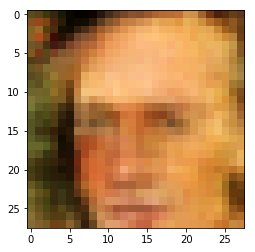

Epoch 1/1... Discriminator Loss: 0.2005... Generator Loss: 2.2647
Epoch 1/1... Discriminator Loss: 0.2282... Generator Loss: 2.3150
Epoch 1/1... Discriminator Loss: 0.8387... Generator Loss: 0.6945
Epoch 1/1... Discriminator Loss: 0.1092... Generator Loss: 3.7745
Epoch 1/1... Discriminator Loss: 0.2724... Generator Loss: 1.9921


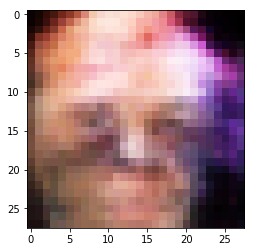

Epoch 1/1... Discriminator Loss: 0.4504... Generator Loss: 1.2782
Epoch 1/1... Discriminator Loss: 0.6216... Generator Loss: 0.9980
Epoch 1/1... Discriminator Loss: 0.2066... Generator Loss: 3.3685
Epoch 1/1... Discriminator Loss: 0.0979... Generator Loss: 3.6842
Epoch 1/1... Discriminator Loss: 0.1323... Generator Loss: 2.7197


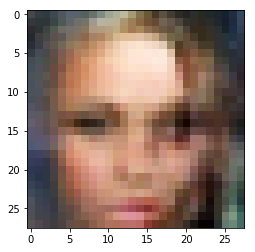

Epoch 1/1... Discriminator Loss: 0.6926... Generator Loss: 0.9359
Epoch 1/1... Discriminator Loss: 0.4439... Generator Loss: 1.4044
Epoch 1/1... Discriminator Loss: 0.7628... Generator Loss: 0.9318
Epoch 1/1... Discriminator Loss: 0.3253... Generator Loss: 1.7051
Epoch 1/1... Discriminator Loss: 0.1161... Generator Loss: 3.3906


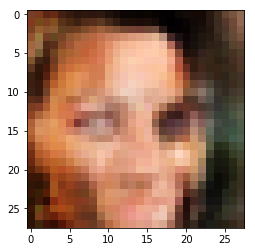

Epoch 1/1... Discriminator Loss: 0.1603... Generator Loss: 2.4907
Epoch 1/1... Discriminator Loss: 0.2992... Generator Loss: 1.8096
Epoch 1/1... Discriminator Loss: 0.2638... Generator Loss: 1.9026
Epoch 1/1... Discriminator Loss: 0.4137... Generator Loss: 1.3389
Epoch 1/1... Discriminator Loss: 1.1791... Generator Loss: 0.5196


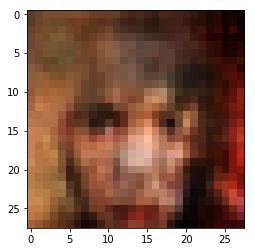

Epoch 1/1... Discriminator Loss: 0.3029... Generator Loss: 2.0389
Epoch 1/1... Discriminator Loss: 0.3443... Generator Loss: 3.0474
Epoch 1/1... Discriminator Loss: 0.5516... Generator Loss: 1.3239
Epoch 1/1... Discriminator Loss: 0.2866... Generator Loss: 2.1759
Epoch 1/1... Discriminator Loss: 0.3931... Generator Loss: 1.9957


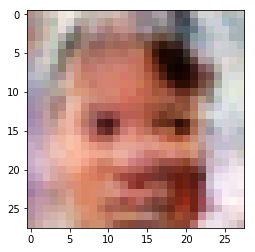

Epoch 1/1... Discriminator Loss: 0.3648... Generator Loss: 1.9880
Epoch 1/1... Discriminator Loss: 0.2550... Generator Loss: 3.3738
Epoch 1/1... Discriminator Loss: 0.7128... Generator Loss: 0.9586
Epoch 1/1... Discriminator Loss: 0.0987... Generator Loss: 3.3380
Epoch 1/1... Discriminator Loss: 0.2553... Generator Loss: 2.1364


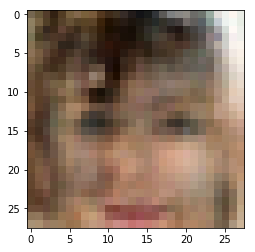

Epoch 1/1... Discriminator Loss: 0.8306... Generator Loss: 5.0989
Epoch 1/1... Discriminator Loss: 0.8905... Generator Loss: 0.7143
Epoch 1/1... Discriminator Loss: 0.6116... Generator Loss: 1.1678
Epoch 1/1... Discriminator Loss: 0.3121... Generator Loss: 1.8765
Epoch 1/1... Discriminator Loss: 0.6894... Generator Loss: 0.9422


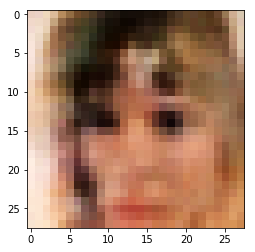

Epoch 1/1... Discriminator Loss: 0.4236... Generator Loss: 1.4383
Epoch 1/1... Discriminator Loss: 0.5185... Generator Loss: 1.2944
Epoch 1/1... Discriminator Loss: 0.1867... Generator Loss: 2.4166
Epoch 1/1... Discriminator Loss: 0.4735... Generator Loss: 1.3319
Epoch 1/1... Discriminator Loss: 0.1193... Generator Loss: 3.4850


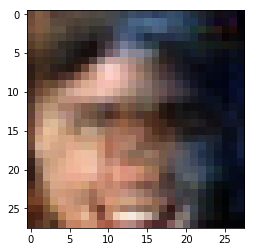

Epoch 1/1... Discriminator Loss: 0.1757... Generator Loss: 3.1178
Epoch 1/1... Discriminator Loss: 0.4735... Generator Loss: 1.3368
Epoch 1/1... Discriminator Loss: 0.9950... Generator Loss: 0.7443
Epoch 1/1... Discriminator Loss: 0.4368... Generator Loss: 1.4538
Epoch 1/1... Discriminator Loss: 0.1142... Generator Loss: 3.3192


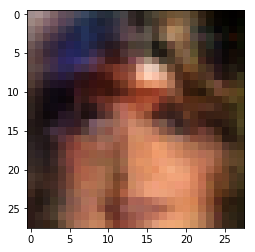

Epoch 1/1... Discriminator Loss: 0.5204... Generator Loss: 1.2361
Epoch 1/1... Discriminator Loss: 0.2020... Generator Loss: 4.1913
Epoch 1/1... Discriminator Loss: 0.5593... Generator Loss: 1.2315
Epoch 1/1... Discriminator Loss: 1.0659... Generator Loss: 1.9997
Epoch 1/1... Discriminator Loss: 0.2574... Generator Loss: 2.5466


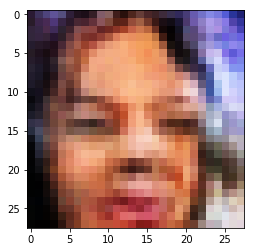

Epoch 1/1... Discriminator Loss: 0.0895... Generator Loss: 3.5928
Epoch 1/1... Discriminator Loss: 1.6056... Generator Loss: 0.2965
Epoch 1/1... Discriminator Loss: 0.3064... Generator Loss: 2.3712
Epoch 1/1... Discriminator Loss: 0.3561... Generator Loss: 2.0826
Epoch 1/1... Discriminator Loss: 0.5051... Generator Loss: 2.8525


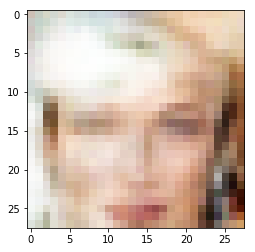

Epoch 1/1... Discriminator Loss: 0.2313... Generator Loss: 2.0040
Epoch 1/1... Discriminator Loss: 0.7507... Generator Loss: 0.9112
Epoch 1/1... Discriminator Loss: 0.7754... Generator Loss: 0.7683
Epoch 1/1... Discriminator Loss: 0.1873... Generator Loss: 2.5206
Epoch 1/1... Discriminator Loss: 0.6447... Generator Loss: 1.0705


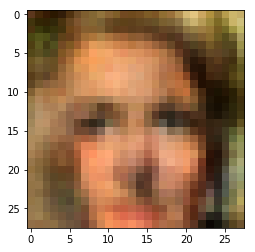

Epoch 1/1... Discriminator Loss: 0.3740... Generator Loss: 1.7380


In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.